In [206]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path as osp
import spatialdata as sd
from skimage.measure import regionprops
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
import torch.optim as optim
import torch.nn as nn
from geomloss import SamplesLoss
import torch.nn.functional as F
import datetime

from config import DATA_PATH
from data import patch_process
from models import utils as model_utils
from eval import utils as eval_utils

# hugginface
from dotenv import load_dotenv
from huggingface_hub import login
load_dotenv(dotenv_path=os.path.expanduser('~/hl/.gutinstinct.env'))
api_token = os.getenv("API_TOKEN")
login(token=api_token)

In [205]:
zarr_path = osp.join(os.path.expanduser(DATA_PATH), "UC6_I.zarr/UC6_I.zarr")
sdata = sd.read_zarr(zarr_path)

/home/b-evelyntong/miniconda3/envs/gutinstinct/lib/python3.11/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


In [3]:
## instantiate a uni model
timm_kwargs = {
   'img_size': 224,
   'patch_size': 32,
   'depth': 24,
   'num_heads': 24,
   'init_values': 1e-5,
   'embed_dim': 1536,
   'mlp_ratio': 2.66667*2,
   'num_classes': 0,
   'no_embed_class': True,
   'mlp_layer': timm.layers.SwiGLUPacked,
   'act_layer': torch.nn.SiLU,
   'reg_tokens': 8,
   'dynamic_img_size': True
  }
model_uni = timm.create_model("hf-hub:MahmoodLab/UNI2-h", pretrained=True, **timm_kwargs)
model_uni = model_uni.to('cuda')
transform = create_transform(**resolve_data_config(model_uni.pretrained_cfg, model=model_uni))
# model_uni.eval()

In [ ]:
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
log_file = f"log_{timestamp}.txt"
patch_id_to_cell_id = patch_process.get_cell_ids_in_patch(sdata, patch_size=200, log_file=log_file)
patch_id_to_pil = patch_process.match_patch_id_to_PIL(sdata, patch_id_to_cell_id, patch_size=200, log_file=log_file)
patch_id_to_cell_id, patch_id_to_pil, patch_id_to_expr = patch_process.match_patch_id_to_expr(sdata, patch_id_to_cell_id, patch_id_to_pil, log_file=log_file)
patch_process.plots_n_visualizations(sdata, patch_id_to_cell_id, patch_id_to_pil, patch_id_to_expr)

In [ ]:
# TODO: process patch and expression for downstream model

In [47]:
dataset_expression_train = model_utils.get_expression(sdata, dataset_patch_train)
dataset_expression_val = model_utils.get_expression(sdata, dataset_patch_val)
dataset_expression_test = model_utils.get_expression(sdata, dataset_patch_test)

In [48]:
train_loader = DataLoader(dataset_patch_train, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset_patch_val, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset_patch_test, batch_size=32, shuffle=True)

In [49]:
train_embeddings, train_cell_ids = model_utils.extract_features(train_loader, model_uni)
val_embeddings, val_cell_ids = model_utils.extract_features(val_loader, model_uni)
test_embeddings, test_cell_ids = model_utils.extract_features(test_loader, model_uni)

In [50]:
train_dataset = TensorDataset(
    torch.tensor(train_embeddings, dtype=torch.float32),
    torch.tensor(dataset_expression_train, dtype=torch.float32)
)

val_dataset = TensorDataset(
    torch.tensor(val_embeddings, dtype=torch.float32),
    torch.tensor(dataset_expression_val, dtype=torch.float32)
)

test_dataset = TensorDataset(
    torch.tensor(test_embeddings, dtype=torch.float32),
    torch.tensor(dataset_expression_test, dtype=torch.float32)
)

# create dataloader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [53]:
# fit fcn model
feature_dim = train_embeddings.shape[1]
model = nn.Sequential(
    nn.Linear(feature_dim, 512),
    nn.ReLU(),
    # nn.Dropout(0.2),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 460)
)
model.to('cuda')

# some setups
criterion = SamplesLoss("sinkhorn", p=2, blur=0.05)
lmd = 0.7        # controls how much we care about the point-wise loss
optimizer = optim.Adam(model.parameters(), lr=1e-5)
train_losses = []
val_losses = []

# es logic
es = None
best_r2 = float('inf')
patience = 5
counter = 0

for epoch in range(20):
    model.train()
    running_train_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to('cuda'), y_batch.to('cuda')
        optimizer.zero_grad()
        y_pred = model(x_batch)
        y_pred_dist = eval_utils.l1_normalize(y_pred)
        y_true_dist = eval_utils.l1_normalize(y_batch)

        # use both point-wise and distributional loss
        mse_loss = F.mse_loss(y_pred, y_batch)
        dist_loss = criterion(eval_utils.l1_normalize(y_pred), eval_utils.l1_normalize(y_batch))
        loss = lmd * mse_loss + (1 - lmd) * dist_loss

        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    train_losses.append(running_train_loss / len(train_loader))

    # validation
    model.eval()
    running_val_loss = 0.0
    y_true_all, y_pred_all = [], []
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to('cuda'), y_val.to('cuda')
            y_pred_val = model(x_val)
            y_pred_dist_val = eval_utils.l1_normalize(y_pred_val)
            y_true_dist_val = eval_utils.l1_normalize(y_val)

            # use both point-wise and distributional loss
            mse_loss = F.mse_loss(y_pred_val, y_val)
            dist_loss = criterion(y_pred_dist_val, y_true_dist_val)
            val_loss = lmd * mse_loss + (1 - lmd) * dist_loss

            running_val_loss += val_loss.item()

            y_true_all.append(y_val.detach().cpu().numpy())
            y_pred_all.append(y_pred_val.detach().cpu().numpy())

    val_losses.append(running_val_loss / len(val_loader))
    val_r2, val_spearman = eval_utils.compute_r2_spearman(y_true_all, y_pred_all)

    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val R2: {val_r2:.4f}, Val Spearman: {val_spearman:.4f}")

    if es is not None:
        if val_r2 < best_r2:
            best_r2 = val_r2
            counter = 0
            best_model_state = model.state_dict()
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

Epoch 1, Train Loss: 0.0868, Val Loss: 0.0841, Val R2: -0.0460, Val Spearman: 0.0004
Epoch 2, Train Loss: 0.0841, Val Loss: 0.0840, Val R2: -0.0194, Val Spearman: 0.0004
Epoch 3, Train Loss: 0.0840, Val Loss: 0.0840, Val R2: -0.0119, Val Spearman: 0.0003
Epoch 4, Train Loss: 0.0840, Val Loss: 0.0840, Val R2: -0.0099, Val Spearman: 0.0003
Epoch 5, Train Loss: 0.0840, Val Loss: 0.0840, Val R2: -0.0090, Val Spearman: 0.0003
Epoch 6, Train Loss: 0.0840, Val Loss: 0.0840, Val R2: -0.0085, Val Spearman: 0.0002
Epoch 7, Train Loss: 0.0840, Val Loss: 0.0840, Val R2: -0.0082, Val Spearman: 0.0002


KeyboardInterrupt: 

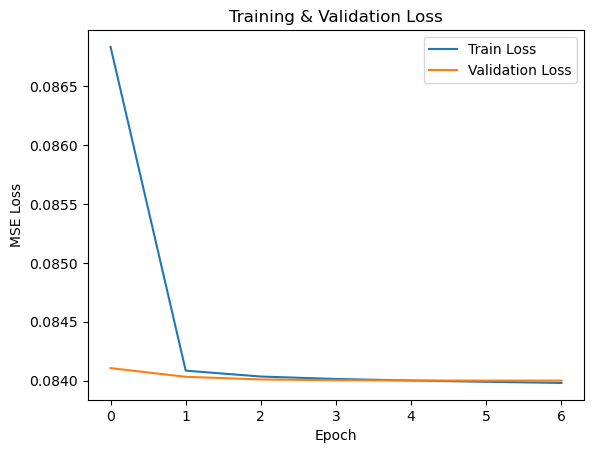

In [54]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()

## Observations
- using a distributional loss in addition to the mse loss does not help the model learn
- train loss plateaus exactly at val loss, the model is not able to overfit
- R2 indicates that the model is worse than predicting the average
- l1 + only wasserstein saw model consistently minimizing loss, but val metrics still bad

Questions to ask:
what loss to use?
is our architecture complete?
any addition we should include?


Notes:
transform from github but didn't use  (create transform function)
